In [1]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.1

In [2]:
!pip install mediapipe scikit-learn matplotlib


In [3]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os


In [4]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils


In [5]:
DATA_DIR = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet"  
LABELS = sorted(os.listdir(DATA_DIR))  

data = []
labels = []

for label in LABELS:
    folder_path = os.path.join(DATA_DIR, label)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)
        
       
        if image is None:
            print(f"Could not load image: {image_path}")
            continue
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        result = hands.process(image)
        
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                data.append(landmarks)
                labels.append(label)



In [6]:
data = np.array(data)
labels = np.array(labels)

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)


In [7]:

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.9952175992348159
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       146
           2       0.00      0.00      0.00         0
           3       1.00      1.00      1.00       162
           4       0.99      0.99      0.99       167
           5       0.99      1.00      0.99       154
           6       1.00      1.00      1.00       171
           7       1.00      0.99      1.00       172
           8       1.00      1.00      1.00       184
           9       1.00      1.00      1.00       150
          10       1.00      0.99      1.00       178
          11       0.99      0.99      0.99       167
          12       0.99      1.00      1.00       160
          13       0.99      1.00      0.99       163
          14       0.99      0.99      0.99       153
          15       1.00      1.00      1.00       139
          16       1.00      1.00      1.00       14

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
import joblib

joblib.dump(clf, "asl_classifier.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

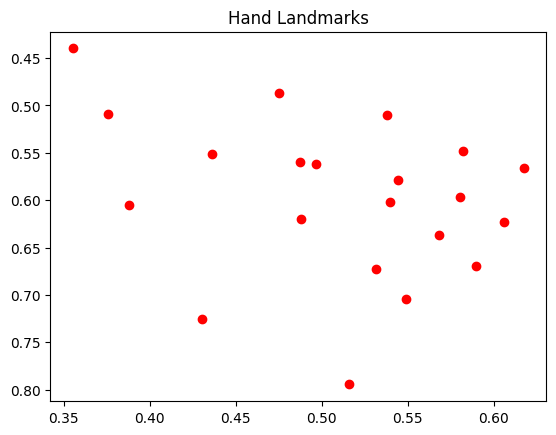

In [9]:
def plot_landmarks(landmarks):
    x = landmarks[::3]
    y = landmarks[1::3]
    plt.scatter(x, y, c="red")
    plt.title("Hand Landmarks")
    plt.gca().invert_yaxis()
    plt.show()

plot_landmarks(data[0])


In [10]:
#single image testing 

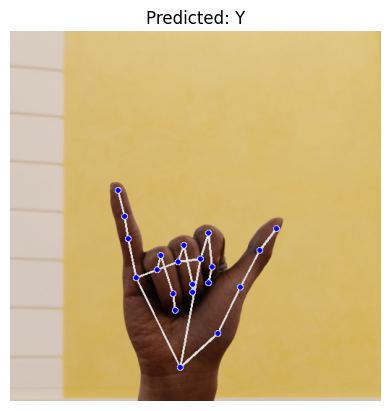

Predicted Class: Y


In [11]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
from matplotlib import pyplot as plt

# Load the saved model and label encoder
clf = joblib.load("asl_classifier.pkl")
label_encoder = joblib.load("label_encoder.pkl")

# Initialize MediaPipe
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

# Function to preprocess and predict
def predict_sign(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load the image.")
        return None
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detect hand landmarks
    result = hands.process(image)
    
    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            
            # Convert to NumPy array and reshape
            landmarks = np.array(landmarks).reshape(1, -1)
            
            # Predict using the trained model
            pred_label = clf.predict(landmarks)
            predicted_class = label_encoder.inverse_transform(pred_label)
            
            # Draw landmarks on the image
            mp_draw.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            
            # Display the image
            plt.imshow(image)
            plt.title(f"Predicted: {predicted_class[0]}")
            plt.axis("off")
            plt.show()
            
            return predicted_class[0]
    else:
        print("No hand landmarks detected.")
        return None

# Test on a single image
image_path = "/kaggle/input/synthetic-asl-alphabet/Test_Alphabet/Y/14274ddb-2c37-4143-aabe-111fd6d5f18e.rgb_0000.png"  # Replace with a valid test image path
predicted_class = predict_sign(image_path)
print(f"Predicted Class: {predicted_class}")


In [12]:
# 2

In [13]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Define paths
data_dir = "/kaggle/input/synthetic-asl-alphabet/Train_Alphabet" 
output_file = "landmarks.csv"  


data = []
labels = []

for label in tqdm(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            continue
        
        # Convert the image to RGB
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Process the image with MediaPipe
        result = hands.process(rgb_image)
        
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                # Extract landmarks
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                data.append(landmarks)
                labels.append(label)
                break  # Use only the first detected hand

# Save to CSV
df = pd.DataFrame(data)
df['label'] = labels
df.to_csv(output_file, index=False)
print(f"Landmarks saved to {output_file}")


100%|██████████| 27/27 [14:06<00:00, 31.37s/it]


Landmarks saved to landmarks.csv


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

# Load the dataset
df = pd.read_csv("landmarks.csv")
X = df.iloc[:, :-1].values  # Landmark features
y = df['label'].values      # Labels

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a custom dataset
class LandmarkDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = LandmarkDataset(X_train, y_train)
test_dataset = LandmarkDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
class LandmarkClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LandmarkClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [16]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, and optimizer
input_size = X_train.shape[1]  # Number of landmark features
num_classes = len(label_encoder.classes_)
model = LandmarkClassifier(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10], Loss: 2.4051
Epoch [2/10], Loss: 1.0872
Epoch [3/10], Loss: 0.6470
Epoch [4/10], Loss: 0.4737
Epoch [5/10], Loss: 0.3773
Epoch [6/10], Loss: 0.3190
Epoch [7/10], Loss: 0.2833
Epoch [8/10], Loss: 0.2528
Epoch [9/10], Loss: 0.2328
Epoch [10/10], Loss: 0.2148


In [17]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Accuracy: 95.27%


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras import metrics, optimizers, Sequential, activations, callbacks
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score
import keras.backend as K
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

In [19]:
train_dir = '/kaggle/input/synthetic-asl-alphabet/Train_Alphabet'
test_dir = '/kaggle/input/synthetic-asl-alphabet/Test_Alphabet'

In [20]:
def load_df(dir_path):
    df = {
        'filename': [],
        'label': []
    }
    classes = os.listdir(dir_path)
    for c in classes:
        path = dir_path + '/' + c

        img_paths = os.listdir(path)

        for img_path in img_paths:
            df['filename'].append(c + '/' + img_path)
            df['label'].append(c)
        
    df = pd.DataFrame(df)
    return df

train_df = load_df(train_dir)
test_df = load_df(test_dir)

In [21]:
train_df.sample(15)

,filename,label
18053,Z/c867ec00-a1d1-460f-bad4-e04744523968.rgb_000...,Z
10175,Q/3630400e-fff2-4a6b-a5e9-6a51c8efd17f.rgb_000...,Q
5961,E/0d4c6a0c-abb1-480a-aad4-419e3dd62ee7.rgb_000...,E
14109,G/b0182f97-8d87-41c8-bd13-41e923699160.rgb_000...,G
18650,Z/b77243cf-9bc3-4780-a49d-d14fd42d40de.rgb_000...,Z
6775,U/f5b255db-fad2-496f-be1f-77372b63d54e.rgb_000...,U
19210,C/de6f1a22-05ff-4407-ab90-726ee0ee83c3.rgb_000...,C
11585,Y/5d725e2f-cc28-4835-8972-6bc043b4a53f.rgb_000...,Y
23982,J/e53fac5e-205e-47b1-be31-20971bb414dd.rgb_000...,J
6341,U/07d65c61-a107-46be-96b6-1fe2476a29d9.rgb_000...,U


In [22]:
train_df['label'].value_counts()

label
N        900
R        900
B        900
I        900
F        900
H        900
E        900
U        900
M        900
X        900
K        900
Q        900
Y        900
Blank    900
S        900
G        900
A        900
O        900
T        900
V        900
Z        900
C        900
P        900
L        900
W        900
D        900
J        900
Name: count, dtype: int64

In [23]:
def show_img(path, row):
    filename = list(row['filename'])[0]
    label = list(row['label'])[0]
    image = cv2.imread(path + '/' + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
    plt.show()

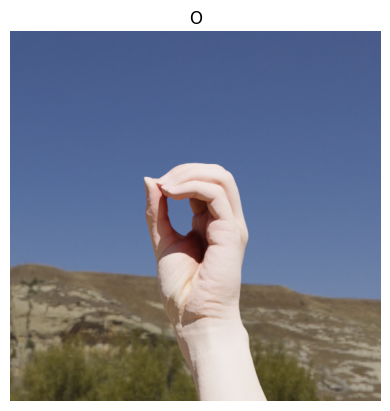

In [24]:
show_img(train_dir, train_df.sample(1))

In [25]:
X = train_df['filename']
y = train_df['label']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2)
print(X_train.shape)
print(X_valid.shape)

(19440,)
(4860,)


In [26]:
train = pd.concat([X_train, y_train], axis=1)
valid = pd.concat([X_valid, y_valid], axis=1)
test = test_df

In [27]:
IMAGE_SIZE = (224, 224)

datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.05,
    height_shift_range=0.05,
#     brightness_range=[0.5, 1.0],
)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_dir,
    x_col='filename',
    y_col='label',
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode='sparse',
    target_size=IMAGE_SIZE
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=valid,
    directory=train_dir,
    x_col="filename",
    y_col="label",
    batch_size=32,
    # color_mode="rgb",
    seed=42,
    shuffle=True,
    class_mode="sparse",
    target_size=IMAGE_SIZE
)

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=test_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    # color_mode="rgb",
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=IMAGE_SIZE
)

Found 19440 validated image filenames belonging to 27 classes.
Found 4860 validated image filenames belonging to 27 classes.
Found 2700 validated image filenames.


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Update the filename to use `.keras` extension
cb = [ModelCheckpoint('model_resnet.keras', save_best_only=True, monitor='val_loss')]


In [29]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
n_class = 27

base_model = tf.keras.applications.ResNet50V2(include_top=False)
base_model.trainable = False

inputs = Input(shape=IMAGE_SIZE + (3,), name='input_layer')
out = base_model(inputs, training=False)
out = GlobalAveragePooling2D()(out)
out = Dense(128, activation='relu')(out)
# out = Dropout(0.2)(out)
out = Dense(n_class, activation='softmax', name='output_layer')(out)
model_resnet = keras.Model(inputs, out)

model_resnet.compile(loss='sparse_categorical_crossentropy',
                     optimizer=optimizers.Adamax(learning_rate=1e-4),
                     metrics=['accuracy'])

model_resnet.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 27)                  │           3,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,830,555 (90.91 MB)

 Trainable params: 265,755 (1.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [30]:
history_resnet = model_resnet.fit(train_generator, epochs=20,
                                  validation_data=valid_generator,
                                  batch_size=128,
                                  callbacks=cb)

Epoch 1/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 460s 734ms/step - accuracy: 0.1292 - loss: 3.1541 - val_accuracy: 0.4216 - val_loss: 2.1523
Epoch 2/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 444s 723ms/step - accuracy: 0.4865 - loss: 1.9458 - val_accuracy: 0.6082 - val_loss: 1.4705
Epoch 3/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 435s 709ms/step - accuracy: 0.6489 - loss: 1.3612 - val_accuracy: 0.6870 - val_loss: 1.1626
Epoch 4/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 432s 705ms/step - accuracy: 0.7102 - loss: 1.1003 - val_accuracy: 0.7344 - val_loss: 0.9860
Epoch 5/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 437s 712ms/step - accuracy: 0.7653 - loss: 0.9164 - val_accuracy: 0.7677 - val_loss: 0.8668
Epoch 6/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 711ms/step - accuracy: 0.7829 - loss: 0.8162 - val_accuracy: 0.7905 - val_loss: 0.7854
Epoch 7/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 711ms/step - accuracy: 0.8146 - loss: 0.7272 - val_accuracy: 0.8051 - val_loss: 0.7281
Epoch 8/20
608/608 ━━━━━━━━━━━━━━━━━━━━ 437s 713ms/step - accuracy: 0.8203 -

In [31]:
history_resnet_temp = history_resnet

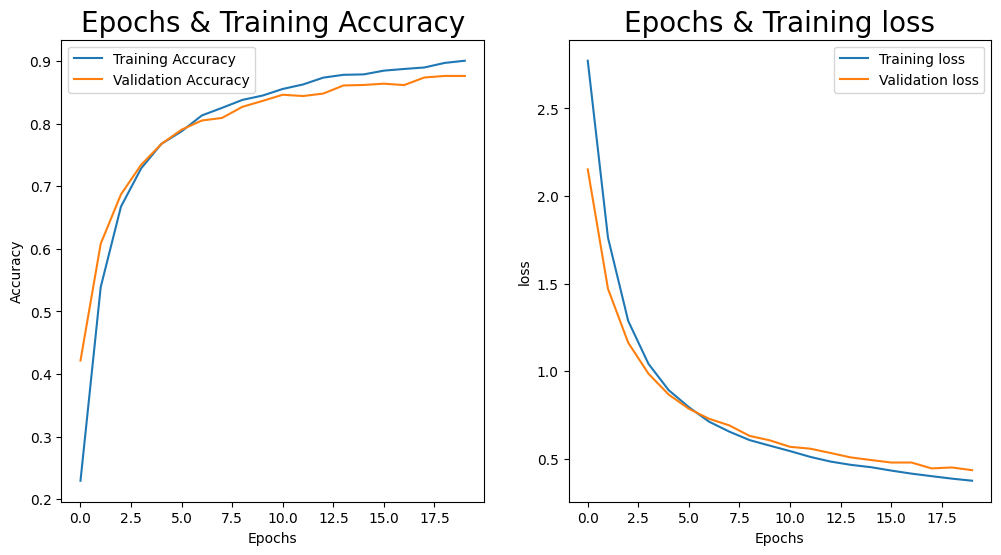

In [32]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet_temp.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet_temp.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet_temp.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet_temp.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [33]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step


In [34]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [35]:
accuracy_score(test['label'], pred_resnet)

0.8918518518518519

In [36]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.93      0.92      0.92       100
           B       0.94      0.83      0.88       100
       Blank       0.99      0.98      0.98       100
           C       0.96      0.96      0.96       100
           D       0.88      0.85      0.86       100
           E       0.84      0.82      0.83       100
           F       0.93      0.91      0.92       100
           G       0.95      0.97      0.96       100
           H       0.98      0.97      0.97       100
           I       0.91      0.89      0.90       100
           J       0.82      0.97      0.89       100
           K       0.84      0.90      0.87       100
           L       0.97      0.92      0.94       100
           M       0.83      0.69      0.75       100
           N       0.75      0.86      0.80       100
           O       0.95      0.96      0.96       100
           P       0.93      0.99      0.96       100
           Q       0.99    

In [37]:
model_resnet.save('resnet50v2_20_ep.hdf5')

In [38]:
history_resnet = model_resnet.fit(train_generator,
                                  initial_epoch=20,
                                  epochs=30,
                                  validation_data=valid_generator,
                                  batch_size=128,
                                  callbacks=cb)

Epoch 21/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 434s 708ms/step - accuracy: 0.9004 - loss: 0.3681 - val_accuracy: 0.8739 - val_loss: 0.4431
Epoch 22/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 436s 711ms/step - accuracy: 0.9034 - loss: 0.3528 - val_accuracy: 0.8800 - val_loss: 0.4206
Epoch 23/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 433s 706ms/step - accuracy: 0.9101 - loss: 0.3418 - val_accuracy: 0.8759 - val_loss: 0.4168
Epoch 24/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 433s 706ms/step - accuracy: 0.9091 - loss: 0.3378 - val_accuracy: 0.8842 - val_loss: 0.4033
Epoch 25/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 437s 713ms/step - accuracy: 0.9088 - loss: 0.3313 - val_accuracy: 0.8811 - val_loss: 0.3994
Epoch 26/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 434s 707ms/step - accuracy: 0.9128 - loss: 0.3239 - val_accuracy: 0.8891 - val_loss: 0.3976
Epoch 27/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 437s 713ms/step - accuracy: 0.9201 - loss: 0.3082 - val_accuracy: 0.8780 - val_loss: 0.3979
Epoch 28/30
608/608 ━━━━━━━━━━━━━━━━━━━━ 435s 709ms/step - accuracy: 

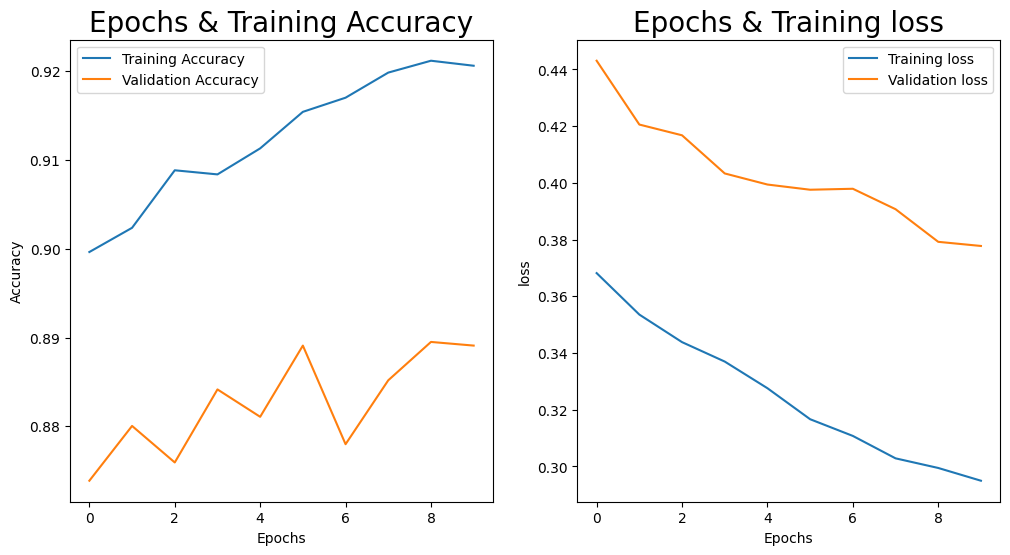

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(history_resnet.history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(history_resnet.history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(history_resnet.history['loss'], '-', label = 'Training loss')
ax[1].plot(history_resnet.history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [40]:
def concate_history(metric='accuracy', history1=history_resnet_temp, 
                    history2=history_resnet):
    history = pd.concat([pd.DataFrame(history1.history[metric]),
                        pd.DataFrame(history2.history[metric])])
    history.columns = [metric]
    history.reset_index(drop=True, inplace=True)
    
    return history

In [41]:
# Accuracy
acc_history = concate_history()

# Validation Accuracy
val_acc_history = concate_history('val_accuracy')

# Loss
loss_history = concate_history('loss')

# Validation Loss
val_loss_history = concate_history('val_loss')

In [42]:
full_history = pd.DataFrame({
    'accuracy' : acc_history['accuracy'].tolist(),
    'val_accuracy' : val_acc_history['val_accuracy'].tolist() ,
    'loss' : loss_history['loss'].tolist() ,
    'val_loss' : val_loss_history['val_loss'].tolist()
}, index=[_ for _ in range(30)])

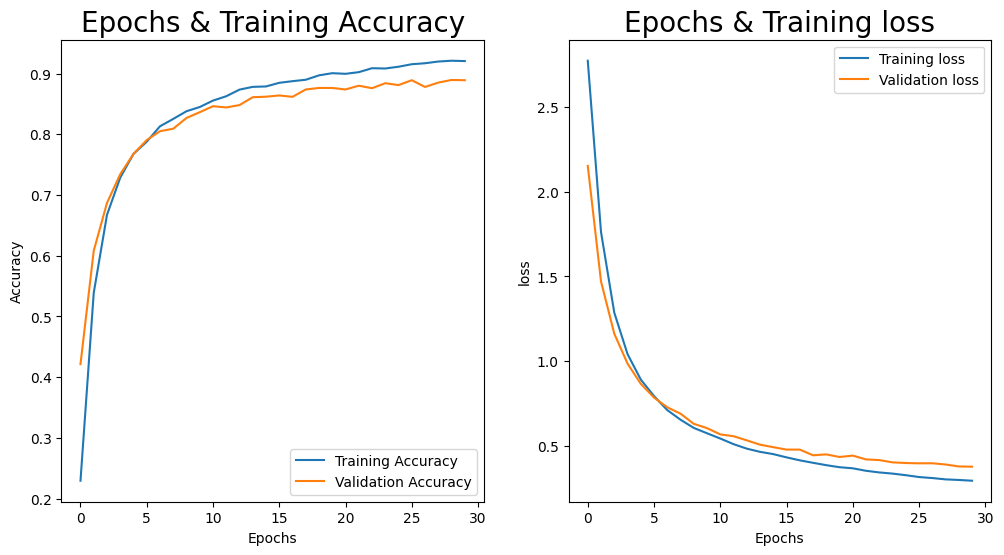

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

ax[0].plot(full_history['accuracy'], '-', label = 'Training Accuracy')
ax[0].plot(full_history['val_accuracy'], '-', label = 'Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize=20)
ax[0].legend(loc='best')

ax[1].plot(full_history['loss'], '-', label = 'Training loss')
ax[1].plot(full_history['val_loss'], '-', label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & Training loss', fontsize=20)
ax[1].legend(loc='best')

plt.show()

In [44]:
test_generator.reset()
pred_resnet = model_resnet.predict(test_generator, verbose=1)

2700/2700 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step


In [45]:
pred_resnet = np.argmax(pred_resnet,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred_resnet = [labels[k] for k in pred_resnet]

In [46]:
accuracy_score(test['label'], pred_resnet)

0.9096296296296297

In [47]:
print(classification_report(test['label'], pred_resnet))

              precision    recall  f1-score   support

           A       0.93      0.95      0.94       100
           B       0.97      0.86      0.91       100
       Blank       0.99      0.99      0.99       100
           C       0.97      0.96      0.96       100
           D       0.94      0.83      0.88       100
           E       0.90      0.83      0.86       100
           F       0.90      0.95      0.92       100
           G       0.95      0.98      0.97       100
           H       0.99      0.96      0.97       100
           I       0.93      0.91      0.92       100
           J       0.90      0.95      0.92       100
           K       0.85      0.93      0.89       100
           L       0.99      0.93      0.96       100
           M       0.74      0.83      0.78       100
           N       0.82      0.80      0.81       100
           O       0.95      0.96      0.96       100
           P       0.93      1.00      0.97       100
           Q       1.00    

In [48]:
model_resnet.save('finalresnet50v2_30_ep.hdf5')